In [1]:
import nltk
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,PorterStemmer
import re
import string
import matplotlib.pyplot as plt

## Hotel Recommender

#### Reading Data

In [50]:
hotels = pd.read_csv('../datasets/hotel_features_dataset.csv')
hotels = hotels.drop('Unnamed: 0',axis=1)

In [51]:
hotels.head()

,name,country,street,region,rating,reviews,amenities,rooms,types,price,official_description
0,WH Hotel,Lebanon,Lyon Street Hamra Emille Edde,NaN,4.0,"{'Excellent': 104, 'Good': 102, 'Average': 51,...","Free High Speed Internet (WiFi),Free breakfast...","Air conditioning,Fireplace,Housekeeping,Room s...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
1,Le Patio Boutique Hotel,Lebanon,"1144 Marfaa, Uruguay Street Solidere",NaN,4.5,"{'Excellent': 213, 'Good': 78, 'Average': 31, ...","Paid private parking nearby,Free High Speed In...","Air conditioning,Housekeeping,Room service,Saf...","Non-smoking rooms,Suites,Family rooms,Smoking ...",121.0,NaN
2,Riviera Hotel Beirut,Lebanon,"Avenue De Paris, Corniche El Manara Riad El Solh",NaN,3.5,"{'Excellent': 90, 'Good': 101, 'Average': 69, ...","Valet parking,Free High Speed Internet (WiFi),...","Air conditioning,Private balcony,Room service,...","Ocean view,Pool view,Non-smoking rooms,Suites,...",NaN,NaN
3,Le Bristol Beyrouth,Lebanon,Mme Curie Street Verdun,NaN,4.5,"{'Excellent': 219, 'Good': 79, 'Average': 25, ...","Free High Speed Internet (WiFi),Pool,Fitness C...","Air conditioning,Room service,Safe,VIP room fa...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
4,Golden Tulip Midtown Hotel And Suites,Lebanon,"Building Number 483, Sidani / Souraty Street M...",NaN,4.0,"{'Excellent': 147, 'Good': 86, 'Average': 32, ...","Free parking,Free High Speed Internet (WiFi),P...","Air conditioning,Room service,Safe,Kitchenette...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN


### Feature Extraction

In [52]:
features = set()

In [53]:
groups = pd.DataFrame(hotels['country'].value_counts().head(20))
groups.sort_values(by='country',ascending=False)

,country
United States,12243
United Kingdom,5726
Italy,5071
France,3481
Turkey,3405
India,3145
Spain,2761
Greece,2254
Germany,1936
Australia,1865


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

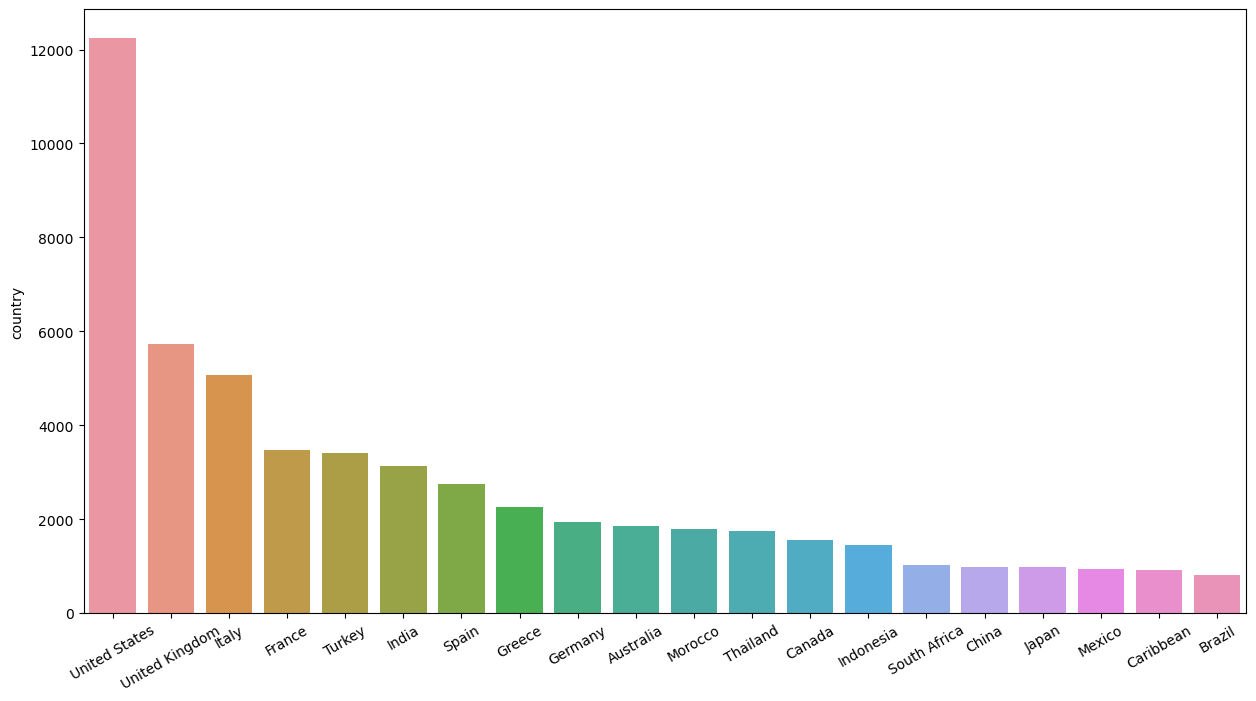

In [54]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15,8), dpi=100, facecolor='w', edgecolor='r')
sns.barplot(x=groups.index,y=groups['country'],data=groups,orient='v')
plt.xticks(rotation=30)

In [7]:
stars = hotels.groupby('rating')['name'].count()
stars

rating
0.0      449
1.0       18
1.5      168
2.0      642
2.5     1760
3.0     4743
3.5    11033
4.0    21324
4.5    23476
5.0     9460
Name: name, dtype: int64

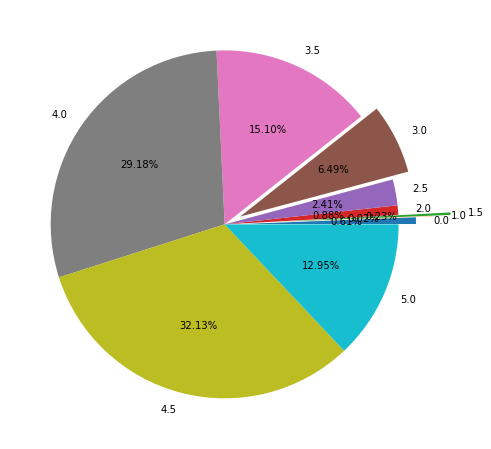

In [8]:
fig1,ax1 = plt.subplots(figsize=(8,8))
ax1.pie(stars,labels=stars.index,explode= (0.1, 0.2,0.3,0,0,0.1, 0, 0,0,0), autopct='%1.2f%%' )
plt.show()

In [55]:
hotels['amenities'].apply(lambda item: [features.add(x) for x in str(item).split(',')])
hotels['rooms'].apply(lambda item: [features.add(x) for x in str(item).split(',')])
hotels['types'].apply(lambda item: [features.add(x) for x in str(item).split(',')])

print()

In [56]:
features

{' DVDs',
 ' music for children',
 '24-hour check-in',
 '24-hour front desk',
 '24-hour security',
 'ATM on site',
 'Additional bathroom',
 'Adult pool',
 'Adults only',
 'Aerobics',
 'Aerobics offsite',
 'Air conditioning',
 'Air purifier',
 'Airport transportation',
 'Allergy-free room',
 'Archery',
 'Archery offsite',
 'BBQ facilities',
 'Babysitting',
 'Badminton',
 'Baggage storage',
 'Banquet room',
 'Bar / lounge',
 'Bath / shower',
 'Bathrobes',
 'Beach',
 'Bicycle rental',
 'Bicycle tours',
 'Bicycles available',
 'Bidet',
 'Billiards',
 'Blackout curtains',
 'Board games / puzzles',
 'Boating',
 'Body wrap',
 'Books',
 'Bottled water',
 'Bowling',
 'Bowling offsite',
 'Breakfast available',
 'Breakfast buffet',
 'Breakfast in the room',
 'Bridal suite',
 'Business Center with Internet Access',
 'Butler service',
 'Cable / satellite TV',
 'Canoeing',
 'Canoeing offsite',
 'Car hire',
 'Casino and Gambling',
 'Chapel / shrine',
 'Children Activities (Kid / Family Friendly)',
 "

In [57]:
features = {x for x in features if pd.notna(x) or x != ''}

In [58]:
features.discard('')
features.discard('nan')
# features.discard(' DVDs')
# features.discard(' music for children')

In [59]:
features

{' DVDs',
 ' music for children',
 '24-hour check-in',
 '24-hour front desk',
 '24-hour security',
 'ATM on site',
 'Additional bathroom',
 'Adult pool',
 'Adults only',
 'Aerobics',
 'Aerobics offsite',
 'Air conditioning',
 'Air purifier',
 'Airport transportation',
 'Allergy-free room',
 'Archery',
 'Archery offsite',
 'BBQ facilities',
 'Babysitting',
 'Badminton',
 'Baggage storage',
 'Banquet room',
 'Bar / lounge',
 'Bath / shower',
 'Bathrobes',
 'Beach',
 'Bicycle rental',
 'Bicycle tours',
 'Bicycles available',
 'Bidet',
 'Billiards',
 'Blackout curtains',
 'Board games / puzzles',
 'Boating',
 'Body wrap',
 'Books',
 'Bottled water',
 'Bowling',
 'Bowling offsite',
 'Breakfast available',
 'Breakfast buffet',
 'Breakfast in the room',
 'Bridal suite',
 'Business Center with Internet Access',
 'Butler service',
 'Cable / satellite TV',
 'Canoeing',
 'Canoeing offsite',
 'Car hire',
 'Casino and Gambling',
 'Chapel / shrine',
 'Children Activities (Kid / Family Friendly)',
 "

In [60]:
features_df = pd.DataFrame(columns=features)

In [61]:
features_df

,hotel_amenity_yoga_classes,Horseback riding,Safe,Open-air bath,hotel_amenity_suites,Fireplace,hotel_amenity_photo_copier_fax_in_business_center,hotel_amenity_shoeshine,hotel_amenity_breakfast_in_the_room,hotel_amenity_pool_with_view,...,Massage,hotel_amenity_shared_lounge_tv_area,hotel_amenity_internet,Bathrobes,hotel_amenity_plunge_pool,hotel_amenity_indoor_play_area_for_children,Diving,Convenience store,Bicycle rental,Complimentary welcome drink


#### Getting each hotel feature as a Vector

In [62]:
amenities  = hotels['amenities'] + ',' +  hotels['rooms'] + ',' +  hotels['types']
amenities[0]

'Free High Speed Internet (WiFi),Free breakfast,Airport transportation,Business Center with Internet Access,Conference facilities,Baggage storage,Concierge,Dry cleaning,Wifi,Bar / lounge,Restaurant,Breakfast available,Breakfast buffet,Car hire,Banquet room,Meeting rooms,Currency exchange,Laundry service,Air conditioning,Fireplace,Housekeeping,Room service,Minibar,Refrigerator,Flatscreen TV,Non-smoking rooms,Suites,Family rooms,Smoking rooms available,Air conditioning,Fireplace,Housekeeping,Room service,Minibar,Refrigerator,Flatscreen TV,Non-smoking rooms,Suites,Family rooms,Smoking rooms available,Non-smoking rooms,Suites,Family rooms,Smoking rooms available'

In [63]:
def extract_features(amenities,features) -> list:
    hotel_features = []
    col_names = pd.Index(features)
    for i,amenity in enumerate(amenities):
        if pd.notna(amenity):
            feats = amenity.split(',')
            row = np.zeros(len(features))
            for feat in feats:
                if feat != '':
                    index = np.where(col_names == feat)[0][0] #index
                    row[index] = 1
            hotel_features.append(row)
    return hotel_features


In [64]:
hotel_features = extract_features(amenities,features)

In [65]:
import pickle

In [66]:
with open('hotel_features.pkl','wb') as hf:
    pickle.dump(hotel_features,hf)

In [67]:
with open('hotel_features.pkl','rb') as hf:
    hotel_features = pickle.load(hf)

In [68]:
features_df = pd.DataFrame(hotel_features,columns= features)
features_df.head()

,hotel_amenity_yoga_classes,Horseback riding,Safe,Open-air bath,hotel_amenity_suites,Fireplace,hotel_amenity_photo_copier_fax_in_business_center,hotel_amenity_shoeshine,hotel_amenity_breakfast_in_the_room,hotel_amenity_pool_with_view,...,Massage,hotel_amenity_shared_lounge_tv_area,hotel_amenity_internet,Bathrobes,hotel_amenity_plunge_pool,hotel_amenity_indoor_play_area_for_children,Diving,Convenience store,Bicycle rental,Complimentary welcome drink
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# add location feature
locations = set(hotels['country'])
locations_list = [c for c in locations]
features_df['country'] = hotels['country'].apply(lambda loc: locations_list.index(loc))
features_df['country']

0         81
1         81
2         81
3         81
4         81
        ... 
62714    170
62715    170
62716     80
62717     74
62718     76
Name: country, Length: 62719, dtype: int64

In [70]:
y= features_df.copy()
y['rating'] = hotels['rating'].apply(lambda x:int(x))
features_df.shape

(62719, 480)

In [71]:
hotels_names = hotels['name']

In [72]:
features_df = features_df.rename(index=hotels_names)
features_df.head()

,hotel_amenity_yoga_classes,Horseback riding,Safe,Open-air bath,hotel_amenity_suites,Fireplace,hotel_amenity_photo_copier_fax_in_business_center,hotel_amenity_shoeshine,hotel_amenity_breakfast_in_the_room,hotel_amenity_pool_with_view,...,hotel_amenity_shared_lounge_tv_area,hotel_amenity_internet,Bathrobes,hotel_amenity_plunge_pool,hotel_amenity_indoor_play_area_for_children,Diving,Convenience store,Bicycle rental,Complimentary welcome drink,country
WH Hotel,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81
Le Patio Boutique Hotel,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81
Riviera Hotel Beirut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81
Le Bristol Beyrouth,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81
Golden Tulip Midtown Hotel And Suites,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81


### KNN Content-Based Recommender

In [134]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [135]:
knn = NearestNeighbors(n_neighbors=20,metric='cosine')

In [136]:
knn.fit(features_df)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [137]:
distances,indecies = knn.kneighbors(features_df)

In [138]:
features_df.shape

(62719, 480)

In [28]:
tsne = TSNE(n_components=2).fit_transform(indecies[:1000])

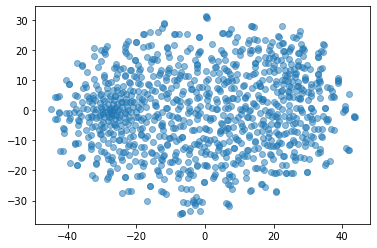

In [29]:
plt.scatter(tsne[:,0],tsne[:,1],alpha=0.5)

### Get Recommendation

In [139]:
def get_recommendation(name,k_indecies,k_distances,features_df,df):
    index = np.where(features_df.index == name)
    neighbours =  k_indecies[index].tolist()[0][1:21]
    distance = k_distances[index][0].tolist()
    for i,neighbour in enumerate(neighbours):
            print(df['name'].loc[neighbour],':',1 - distance[i+1])

In [140]:
get_recommendation('Hotel Pamphylia',indecies,distances,features_df,hotels)

Collage Taksim : 0.8955473256792901
Bika Suites Istanbul Hotel : 0.8917786000769994
The Westist Hotel & Spa : 0.8902638145194517
Nova Plaza Taksim Square : 0.8837427700960543
Tolga Hotel : 0.8799714013941744
Anka Hotel : 0.8772800312127007
Hotel Fatih Istanbul : 0.8771182271731442
Milport Hotel Levent Istanbul : 0.8749572785196142
Akgun Hotel : 0.8749572785196142
Prima Hotel : 0.8740093185210837
Seven Hills Hotel - Special Category : 0.8740093185210837
Miss Istanbul Hotel & Spa : 0.873684210526316
Mood Design Suites : 0.8723897925801722
Away Suites : 0.871169214929605
Metin Han : 0.8708896333420233
Grand Palace Hotel : 0.8708896333420233
Teos Hotel : 0.870571500132014
Petrol Hotel Palace : 0.8700279025141457
Gumusyan Hotel : 0.8680072191564654


In [169]:
def get_feature_recommendation(features,knn,n_neighbors):
    vec = np.zeros(len(features_df.columns))
    data = list(features_df.columns)
    for feat in features:
        try:
            index = data.index(feat)
            vec[index] = 1
        except:
            continue
    distances,indecies = knn.kneighbors([vec],n_neighbors)
    hotels = []
    for i,ind in enumerate(indecies):
        hotels.append((features_df.iloc[ind].index,distances[i]))
    return hotels

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

In [23]:
def similarity(one,two,df):
    one = df.loc[one]
    two = df.loc[two]
    return np.dot(one,two)/ np.multiply(norm(one),norm(two))

In [42]:
similarity("Hampton Inn Suites Bolingbrook","Warwick Stone 55 Hotel",features_df)

0.9982382303099133

In [4]:
import pickle

In [36]:
import pickle
with open("hotels_knn.pkl",'wb') as f:
    pickle.dump([distances,indecies],f)

In [125]:
with open("hotels_knn.pkl",'rb') as f:
    model = pickle.load(f)

In [126]:
k_distances,k_indecies = model

In [7]:
feats =['72 smoke-free guestrooms,Daily housekeeping,Restaurant and bar/lounge,Breakfast available,6 meeting rooms,24-hour front desk,Air conditioning,Garden,Laundry service,Conference space,Multilingual staff,Concierge services,Free WiFi ,Free WiFi,BROOKLYN KING ROOM,BROOKLYN QUEEN ROOM,BUNK BED,MANHATTAN VIEW KING ROOM,STUDIO QUEEN ROOM,Air conditioning,Minibar,Bathrobes,Iron/ironing board,Blackout drapes/curtains,In-room massage available,Individually decorated,Rainfall showerhead,Shower only,Free toiletries,Hair dryer,40-inch Smart TV,Premium TV channels,Smart speaker,Free newspaper,Free WiFi,Free long-distance calls,Daily housekeeping,In-room safe,']

In [129]:
feats = '72 smoke-free guestrooms,Daily housekeeping,Restaurant and bar/lounge,Breakfast available,6 meeting rooms,24-hour front desk,Air conditioning,Garden,Laundry service,Conference space,Multilingual staff,Concierge services,Free WiFi,BROOKLYN KING ROOM,BROOKLYN QUEEN ROOM,BUNK BED,MANHATTAN VIEW KING ROOM,STUDIO QUEEN ROOM,Air conditioning,Minibar,Bathrobes,Iron/ironing board,Blackout drapes/curtains,In-room massage available,Individually decorated,Rainfall showerhead,Shower only,Free toiletries,Hair dryer,40-inch Smart TV,Premium TV channels,Smart speaker,Free newspaper,Free WiFi,Free long-distance calls,Daily housekeeping,In-room safe'.split(',')
knn1 = '10 guestrooms,Daily housekeeping,24-hour room service,Airport shuttle,24-hour front desk,Coffee/tea in a common area,Air conditioning,Garden,Laundry service,Concierge services,Free newspapers in the lobby,Luggage storage,Free WiFi ,Free WiFi,Single Room,Double or Twin Room,Standard Triple Room,Family Room,Economy Double Room,Apartment, 2 Bedrooms,Family Condo, 2 Bedrooms, City View,Classic Apartment,Family Apartment,Air conditioning,Slippers,Soundproofed rooms,Private bathroom,Shower only,Free toiletries,Hair dryer,LCD TV,Satellite TV channels,Free WiFi,Daily housekeeping,In-room safe'.split(',')
knn1

['10 guestrooms',
 'Daily housekeeping',
 '24-hour room service',
 'Airport shuttle',
 '24-hour front desk',
 'Coffee/tea in a common area',
 'Air conditioning',
 'Garden',
 'Laundry service',
 'Concierge services',
 'Free newspapers in the lobby',
 'Luggage storage',
 'Free WiFi ',
 'Free WiFi',
 'Single Room',
 'Double or Twin Room',
 'Standard Triple Room',
 'Family Room',
 'Economy Double Room',
 'Apartment',
 ' 2 Bedrooms',
 'Family Condo',
 ' 2 Bedrooms',
 ' City View',
 'Classic Apartment',
 'Family Apartment',
 'Air conditioning',
 'Slippers',
 'Soundproofed rooms',
 'Private bathroom',
 'Shower only',
 'Free toiletries',
 'Hair dryer',
 'LCD TV',
 'Satellite TV channels',
 'Free WiFi',
 'Daily housekeeping',
 'In-room safe']

In [130]:
vec = np.zeros(len(features_df.columns))
data = list(features_df.columns)
for feat in knn1:
    try:
        index = data.index(feat)
        vec[index] = 1
    except:
        continue
vec.shape

(480,)

In [131]:
vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [85]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [86]:
X_train,X_test,y_train,y_test = train_test_split(features_df,y['rating'],random_state=42)

In [87]:
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [88]:
knn = KNeighborsClassifier(n_neighbors=6,)

In [89]:
y_train

51747    3
11380    4
50135    4
61522    4
4928     4
        ..
62570    4
38158    3
860      3
15795    4
56422    4
Name: rating, Length: 47039, dtype: int64

In [90]:
knn.fit(X_train,y_train)
X_train.shape

(47039, 480)

In [91]:
y_model = knn.predict(X_test)

In [92]:
from sklearn.metrics import accuracy_score

In [93]:
accuracy_score(y_test,y_model)

0.5271683673469387

In [64]:
y['rating'].unique()

array([4, 3, 5, 0, 2, 1])

In [ ]:
distances,indecies = knn.kneighbors(features_df)

In [113]:
with open('hotels_knn_classifier.pkl','rb') as hf:
       model =  pickle.load(hf)
distances,indecies = model

In [114]:
neighbours = indecies[index].tolist()[1:21]
distance = distances[index].tolist()
for i,neighbour in enumerate(neighbours):
        print(hotels['name'].loc[neighbour],':', distance[i])

The Maven Hotel : 2.984126984126984
Brandon Center Hotel : 4.172795526043613
JiLin World Trade Winning Hotel : 4.547855274558714
Kadak Garden Hotel : 4.596519546082203
Commodore Regent : 4.612263726239436


In [115]:
from sklearn.decomposition import PCA

In [116]:
pca = PCA(n_components=2)

In [121]:
vis = pca.fit_transform(indecies)[:1000]

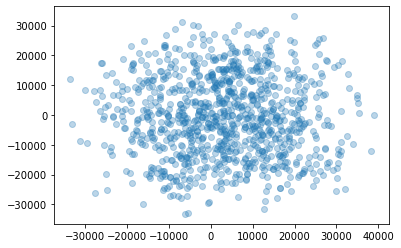

In [122]:
plt.scatter(x=vis[:,0],y=vis[:,1],alpha=0.3)

In [170]:
get_feature_recommendation(knn1,knn,20)

[(Index(['The Bay', 'Kaani Beach Hotel', 'Cotton Bay Hotel',
         'Litia Sini Beach Resort', 'Crystal Sands Beach Hotel',
         'Eureka Airport Inn', 'Hotel Astrus', 'Travel Lodge Maldives',
         'Iberry Inn', 'Travellers Point Hotel', 'Hanifaru Transit Inn',
         'Mystik Life Style', 'Cocos Village Bungalows', 'Hotel Dolce Vita',
         'Asdu Sun Island', 'Sinalei Reef Resort & Spa', 'Matreshka Hotel',
         'Hotel Villa de Laredo', 'Noomoo', 'Matisov Domik'],
        dtype='object'),
  array([0.59910814, 0.61270167, 0.625     , 0.62860932, 0.64644661,
         0.64644661, 0.65184469, 0.6645898 , 0.66666667, 0.66666667,
         0.67120203, 0.67974369, 0.68019893, 0.68377223, 0.68377223,
         0.68377223, 0.68765248, 0.6913933 , 0.69500286, 0.69848866]))]

In [ ]:
x = features_df.iloc[10
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    
                    3]